---
title: "3. Recurrent Neural Networks"
image: "disaster.jpeg"
author: "Diegulio"
format: 
  html:
    code-fold: false
jupyter: python3
---

# 3. Recurrent Neural Networks

As we see in the previous notebooks. Embeddings solve the problem of have a good representation of text! But we still having some other problems:

The input of the Dense layers could vary in size! There are sequences of differents size! (Remember that we solve it with padding and truncation)
Due to sequences could be large, there is a lot of computational costs!
Layers are not sharing information! (They have different weighths) So we are not taking into account the order of the words, the context, or the words around
To take care of this points, we will apply Recurrent Neural Networks in this notebook! 💥💥💥💥

I recommend spend time in understand what is happen inside RNN. For this I see a lot of videos and read some blogs. I will let you some of them here:

- https://www.youtube.com/watch?v=Y2wfIKQyd1I
- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.youtube.com/watch?v=AsNTP8Kwu80


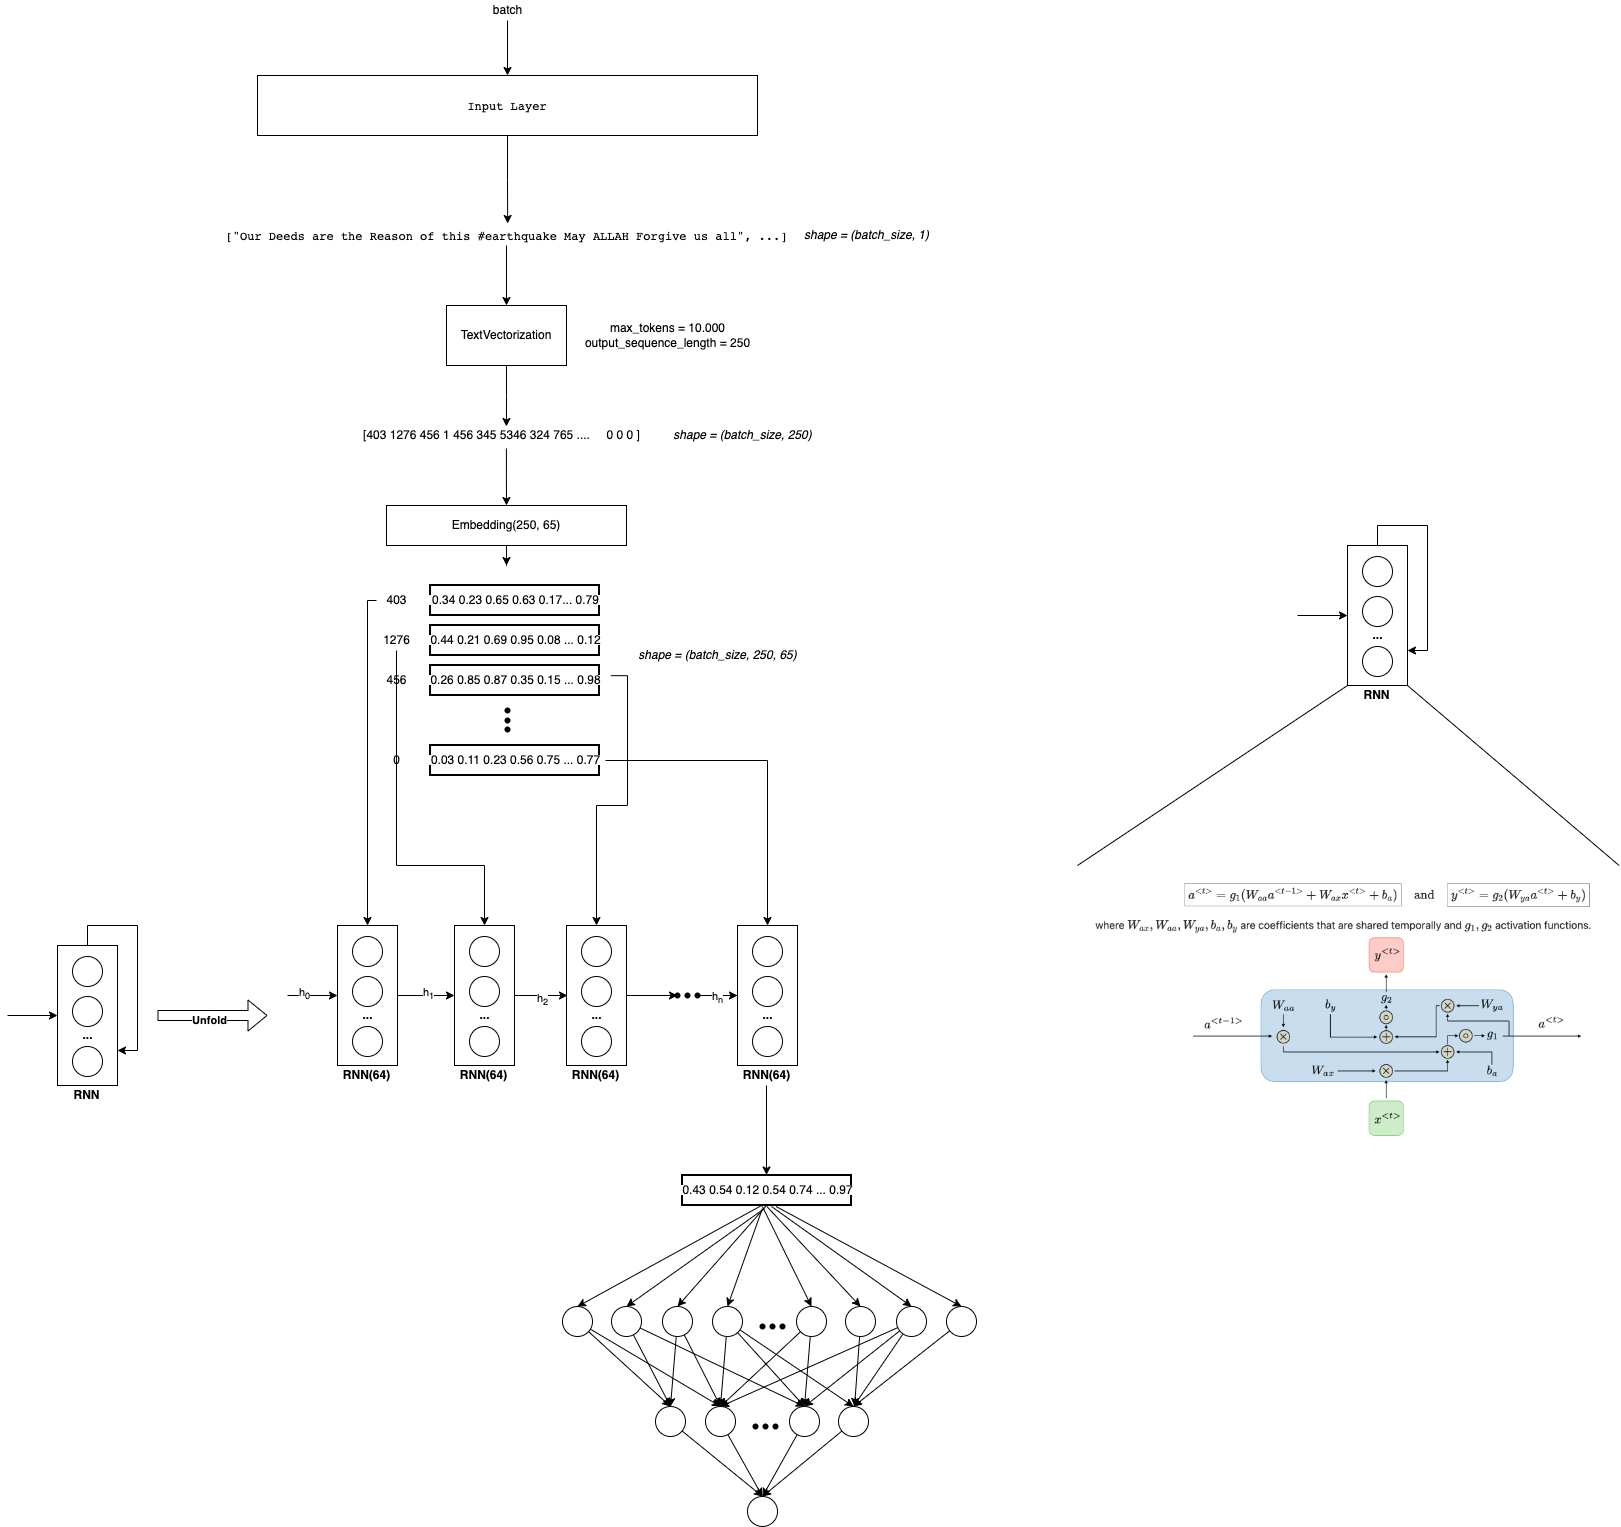

> Remember that this belong to a NLP Notebook series where I am learning and testing different NLP approachs in this competition. Like NN, Embedding, RNN, Transformers, HuggingFace, etc.

> To see the other notebooks visit: https://www.kaggle.com/code/diegomachado/seqclass-nn-embed-rnn-lstm-gru-bert-hf

## Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import gc


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Lambda
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
#import tensorflow_hub as hub
#import tensorflow_text as text # Bert preprocess uses this 
from tensorflow.keras.optimizers import Adam

import re
import nltk
from nltk.corpus import stopwords
import string
from gensim.models import KeyedVectors

#nltk.download('stopwords')

## Data

In [2]:
# Load data
train = pd.read_csv("/kaggle/input/df-split/df_split/df_train.csv")
test = pd.read_csv("/kaggle/input/df-split/df_split/df_test.csv")

X_train = train[[col for col in train.columns if col != 'target']].copy()
y_train = train['target'].copy()

X_test = test[[col for col in test.columns if col != 'target']].copy()
y_test = test['target'].copy()

In [3]:
# Tensorflow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train.text, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test.text, y_test))
train_ds

2022-12-12 02:13:04.769598: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [4]:
# Vectorization Layer

max_features = 10000 # Vocabulary (TensorFlow select the most frequent tokens)
sequence_length = 40 # It will pad or truncate sequences
vectorization_layer = TextVectorization(
    max_tokens = max_features,
    output_sequence_length = sequence_length,
)

# Adapt is to compute metrics (In this case the vocabulary)
vectorization_layer.adapt(X_train.text)

2022-12-12 02:13:04.955961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Data Pipeline

Now we need to prepare the data pipeline:

batch -> cache -> prefetch

- `Batch` : Create a set of samples (Those will be processed together in the model)
- `Cache`: The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.
- `Prefetch` : This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

Optional: You can do it another steps like `shuffle`

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

## Model

As Twitter Embedding is the best so far. We will continue use it!

In this case we will use the SimpleRNN Tensorflow Layer. Furthermore, we also going to use the Bidirectional Layer. This is basically to apply two RNN, one that process the sequence from `left to right`, and another that process the sequence from `right to left`. It makes sense because we will know all the sequence input at the moment we want to predict. Also, I prove with and without Bidirectional, and with Bidirectional improve a lot wit respect without it. I think that in timeseries is not a good idea because we don't know the future at the moment we want predict.

[Click here to read about Bidirectional RNN](https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66)

👀 Also, note that now we will define explicitly the activation functions in the NN. Also we will apply the sigmoid function at the end. So know the loss functions should has: `from_logits=False` or let it by default. (I just do it because I want to prove both ways)


In [6]:
# GloVe Twitter Embedding
wv = KeyedVectors.load_word2vec_format('../input/twitter-word2vecs-wordvecs-from-godin/word2vec_twitter_tokens.bin', 
                                       binary=True,
                                       unicode_errors='ignore')

In [7]:
# Build embedding matrix 

voc = vectorization_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# We have to construct the embedding matrix with weigths from our own vocabulary
# shape embedding matrix : (vocab_size, embedding_dim)
num_tokens = len(voc)
embedding_dim = 400 # we download glove 100 dimension
hits = []
misses = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in wv:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_vector = wv[word]
        embedding_matrix[i] = embedding_vector
        hits.append(word)
    else:
        misses.append(word)
print("Converted %d words (%d misses)" % (len(hits), len(misses)))

Converted 7873 words (2127 misses)


In [8]:
# Model 
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
    ),
    layers.SpatialDropout1D(0.3),
    layers.Bidirectional(layers.SimpleRNN(64, dropout = 0.2, recurrent_dropout = 0.2)),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 40)                0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 400)           4000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 400)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               59520     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5

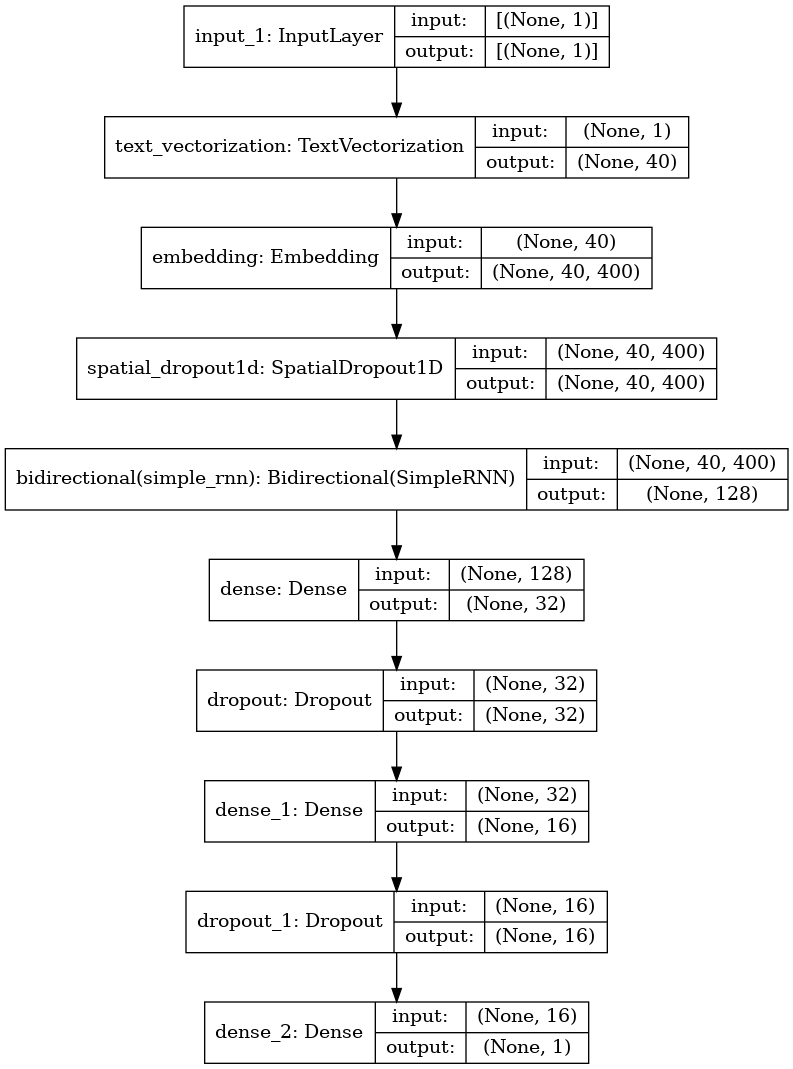

In [10]:
plot_model(model, show_shapes=True)

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [12]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback]
)


Epoch 1/100
191/191 [==============================] - 16s 70ms/step - loss: 0.6465 - binary_accuracy: 0.6245 - val_loss: 0.5218 - val_binary_accuracy: 0.7610
Epoch 2/100
191/191 [==============================] - 13s 67ms/step - loss: 0.5322 - binary_accuracy: 0.7484 - val_loss: 0.4914 - val_binary_accuracy: 0.7722
Epoch 3/100
191/191 [==============================] - 14s 71ms/step - loss: 0.5156 - binary_accuracy: 0.7675 - val_loss: 0.4749 - val_binary_accuracy: 0.7846
Epoch 4/100
191/191 [==============================] - 13s 70ms/step - loss: 0.5046 - binary_accuracy: 0.7768 - val_loss: 0.4774 - val_binary_accuracy: 0.7912
Epoch 5/100
191/191 [==============================] - 14s 73ms/step - loss: 0.4972 - binary_accuracy: 0.7811 - val_loss: 0.4751 - val_binary_accuracy: 0.7827
Epoch 6/100
191/191 [==============================] - 14s 71ms/step - loss: 0.4820 - binary_accuracy: 0.7806 - val_loss: 0.4750 - val_binary_accuracy: 0.7774
Epoch 7/100
191/191 [=========================

## Predict Test

In [13]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [14]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
preds = model.predict(topred_ds)

In [16]:
# Now we not apply sigmoid function here because or activation function
test_df["target"] = tf.round(preds)
test_df["target"] = test_df["target"].astype(int)

In [17]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [18]:
sub.to_csv("RNN_submission.csv", index = False)

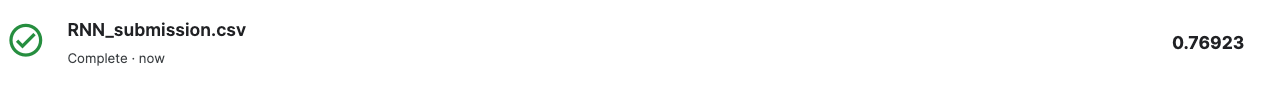

## Observations

RNN has some benefits. But also some disadvantages (See the references). One of them, maybe the most named is the Exploding-Vanishing gradient problem!

> To improve our solution, maybe we could try adding more RNN layers. Note that for this we need to set up `return_sequences = True` in the previous LSTM layers. Thats because by default the output of a RNN or LSTM layer is the last hidden state, but to feed to another LSTM we need a sequence (and this sequence is given thanks to `return_sequences = True`). And of course we could try hyperparameter optimization

So there are other arquitectures that take care of it. We will explore those now:

- LSTM
- GRU

# LSTM (Long-Short Term Memory)

Here I will let you with some LSTM references: 

- https://www.youtube.com/watch?v=LfnrRPFhkuY
- https://www.youtube.com/watch?v=YCzL96nL7j0
- https://www.youtube.com/watch?v=QciIcRxJvsM

if we know how to apply RNN in Python|Tensorflow, it is pretty straightforward apply LSTM, you just need change one layer!

In [19]:
#num_tokens = vectorization_layer.vocabulary_size()
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
    ),
    layers.SpatialDropout1D(0.3),
    layers.Bidirectional(layers.LSTM(128, dropout = 0.3, recurrent_dropout = 0.3)),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid')
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 400)           4000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 400)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               541696    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

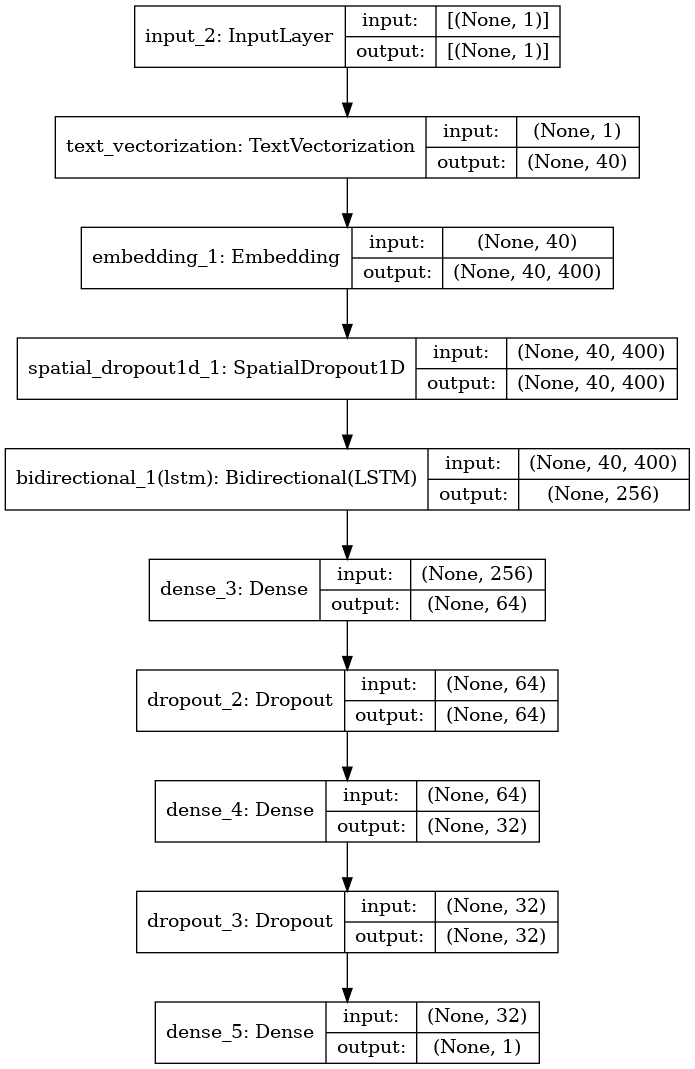

In [21]:
plot_model(model, show_shapes=True)

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [23]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback]
)


Epoch 1/100
191/191 [==============================] - 86s 424ms/step - loss: 0.5507 - binary_accuracy: 0.7210 - val_loss: 0.4614 - val_binary_accuracy: 0.7866
Epoch 2/100
191/191 [==============================] - 81s 423ms/step - loss: 0.4721 - binary_accuracy: 0.7921 - val_loss: 0.4525 - val_binary_accuracy: 0.7899
Epoch 3/100
191/191 [==============================] - 80s 419ms/step - loss: 0.4589 - binary_accuracy: 0.7966 - val_loss: 0.4430 - val_binary_accuracy: 0.7925
Epoch 4/100
191/191 [==============================] - 80s 420ms/step - loss: 0.4388 - binary_accuracy: 0.8079 - val_loss: 0.4451 - val_binary_accuracy: 0.7938
Epoch 5/100
191/191 [==============================] - 80s 418ms/step - loss: 0.4340 - binary_accuracy: 0.8038 - val_loss: 0.4482 - val_binary_accuracy: 0.7899
Epoch 6/100
191/191 [==============================] - 82s 427ms/step - loss: 0.4170 - binary_accuracy: 0.8136 - val_loss: 0.4428 - val_binary_accuracy: 0.8017
Epoch 7/100
191/191 [===================

## Predict Test

In [24]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [25]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
preds = model.predict(topred_ds)

In [27]:
preds.shape

(3263, 1)

In [28]:
# Now we not apply sigmoid function here because or activation function
test_df["target"] = tf.round(preds)
test_df["target"] = test_df["target"].astype(int)

In [29]:
test_df["target"] = tf.round(preds)
test_df["target"] = test_df["target"].astype(int)

In [30]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [31]:
sub.to_csv("LSTM_submission.csv", index = False)

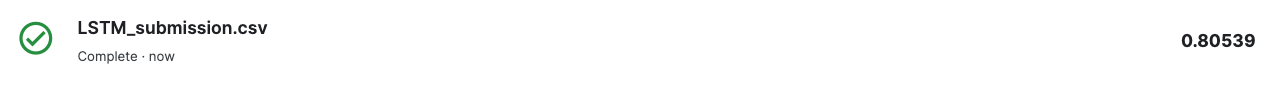

## Observations:

Nice, we find our better solution so far! 

> To improve our solution, maybe we could try adding more LSTM. Note that for this we need to set up `return_sequences = True` in the previous LSTM layers. Thats because by default the output of a RNN or LSTM layer is the last hidden state, but to feed to another LSTM we need a sequence (and this sequence is given thanks to `return_sequences = True`). And of course we could try hyperparameter optimization

Now we will try GRU Recurrent Neural Network

# GRU (Gated Recurrent Unit)

Here I will let you with some GRU references:

- https://www.youtube.com/watch?v=tOuXgORsXJ4
- https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

Same as LSTM, it is pretty straighforward to implement it in Tensorflow!

In [32]:
model = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorization_layer,
    layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False
    ),
    layers.SpatialDropout1D(0.3),
    layers.Bidirectional(layers.GRU(64, dropout = 0.3, recurrent_dropout = 0.3)),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'sigmoid')
])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 40)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 400)           4000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 400)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               178944    
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)               

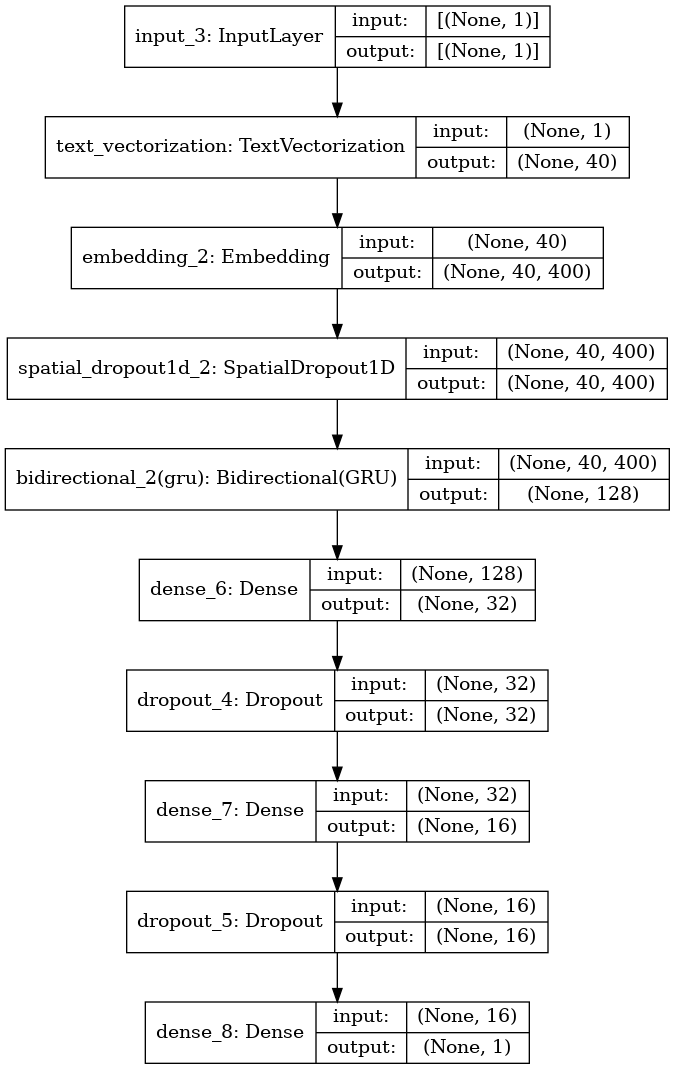

In [34]:
plot_model(model, show_shapes=True)

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

In [36]:
early_stop_callback = EarlyStopping(patience = 5)
epochs = 100
history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=epochs,
    callbacks = [early_stop_callback]
)


Epoch 1/100
191/191 [==============================] - 72s 349ms/step - loss: 0.5856 - binary_accuracy: 0.7061 - val_loss: 0.4792 - val_binary_accuracy: 0.7840
Epoch 2/100
191/191 [==============================] - 66s 343ms/step - loss: 0.4838 - binary_accuracy: 0.7854 - val_loss: 0.4513 - val_binary_accuracy: 0.7925
Epoch 3/100
191/191 [==============================] - 66s 348ms/step - loss: 0.4621 - binary_accuracy: 0.7947 - val_loss: 0.4445 - val_binary_accuracy: 0.8056
Epoch 4/100
191/191 [==============================] - 65s 341ms/step - loss: 0.4617 - binary_accuracy: 0.8025 - val_loss: 0.4417 - val_binary_accuracy: 0.7965
Epoch 5/100
191/191 [==============================] - 66s 344ms/step - loss: 0.4419 - binary_accuracy: 0.8080 - val_loss: 0.4337 - val_binary_accuracy: 0.8017
Epoch 6/100
191/191 [==============================] - 65s 340ms/step - loss: 0.4282 - binary_accuracy: 0.8115 - val_loss: 0.4381 - val_binary_accuracy: 0.8030
Epoch 7/100
191/191 [===================

## Predict Test

In [37]:
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [38]:
topred_ds = tf.data.Dataset.from_tensor_slices(test_df.text)
AUTOTUNE = tf.data.AUTOTUNE
topred_ds = topred_ds.batch(32).cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
preds = model.predict(topred_ds)

In [40]:
# Now we not apply sigmoid function here because or activation function
test_df["target"] = tf.round(preds)
test_df["target"] = test_df["target"].astype(int)

In [41]:
test_df["target"] = tf.round(preds)
test_df["target"] = test_df["target"].astype(int)

In [42]:
sub = test_df[["id", "target"]]
sub

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [43]:
#sub.to_csv("GRU_submission.csv", index = False)
sub.to_csv("submission.csv", index = False)

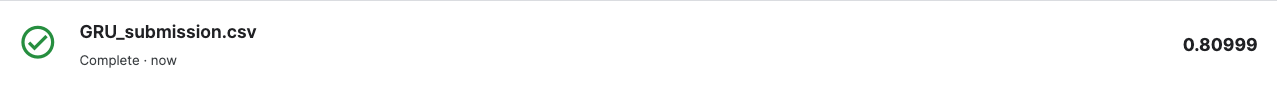

A little better than LSTM! 

# Conclusions:

We could note that combining Embeddings + RNN we could get better results. And thats thanks to their benefits like:
- Share Weights
- Sequence Order Importance
- Capability of manage different inputs sizes
And more.

But, RNN are to computationally expensive! One important thing of RNN is that we could not paralellize!!! What can we use that take context into account and can be faster? Answer : TRANSFORMERS!  😎😎😎😎😎😎😎😎😎

In the next notebook, we will Apply Transformers, specifically BERT! 